In [158]:
"""
STEP 1  –  Build clean BCW list + CRSP monthly file
===================================================

• bcwlist.csv  : repeating 5-column blocks
    rank | company | permno | year | (blank)

• crsp_1926_2020.csv : monthly CRSP returns

Outputs
--------
bcw_clean.parquet   list_year | rank | company | PERMNO
crsp_clean.parquet  CRSP monthly (clean), incl. mktcap & month stamp
"""

from pathlib import Path
import pandas as pd
import numpy as np

# ------------------------------------------------------------------
# File locations
# ------------------------------------------------------------------
ROOT      = Path(".")
BCW_CSV   = ROOT / "bcwlist.csv"
CRSP_CSV  = ROOT / "crsp_1926_2020.csv"

# ------------------------------------------------------------------
# 1) Parse bcwlist.csv  (5-column stride)
# ------------------------------------------------------------------
raw = pd.read_csv(BCW_CSV, dtype=str)

blocks = []
cols = list(raw.columns)
stride = 5   # rank,company,permno,year,blank

for i in range(0, len(cols), stride):
    if i + 3 >= len(cols):
        break
    sub = raw.iloc[:, i : i + 4].copy()   # first four columns
    hdr = [str(c).strip().lower() for c in sub.columns]
    if hdr != ["rank", "company", "permno", "year"]:
        continue
    sub.columns = ["rank", "company", "PERMNO", "list_year"]
    blocks.append(sub)

if not blocks:
    raise ValueError("No valid rank/company/permno/year blocks found in bcwlist.csv.")

bcw = pd.concat(blocks, ignore_index=True)

# Clean datatypes
bcw["rank"]      = pd.to_numeric(bcw["rank"], errors="coerce")
bcw["PERMNO"]    = pd.to_numeric(bcw["PERMNO"], errors="coerce")
bcw["list_year"] = pd.to_numeric(bcw["list_year"], errors="coerce")
bcw["company"]   = bcw["company"].astype(str).str.strip()

bcw = (
    bcw.dropna(subset=["rank", "PERMNO", "list_year"])
       .query("1984 <= list_year <= 2020")
       .reset_index(drop=True)
)

print(f"✓ BCW rows with PERMNO: {len(bcw):,}")

# ------------------------------------------------------------------
# 2) Clean CRSP monthly per your spec
# ------------------------------------------------------------------
crsp = pd.read_csv(CRSP_CSV, parse_dates=["date"])

# 2.1 keep common shares (SHRCD 10 or 11)
crsp = crsp[crsp["SHRCD"].isin([10, 11])]

# 2.2 restrict to NYSE / AMEX / NASDAQ
crsp = crsp[crsp["EXCHCD"].isin([1, 2, 3])]

# 2.3 mask negative prices (−999 etc.)
crsp["PRC"] = crsp["PRC"].mask(crsp["PRC"] < 0)

# 2.4 build market cap and month stamp
crsp["mktcap"] = crsp["PRC"] * crsp["SHROUT"]
crsp["month"]  = crsp["date"].dt.to_period("M").dt.to_timestamp("M")

print(f"✓ CRSP rows kept: {len(crsp):,}")

# ------------------------------------------------------------------
# 3) Save tidy artefacts
# ------------------------------------------------------------------
bcw.to_parquet ("bcw_clean.parquet",  index=False)
crsp.to_parquet("crsp_clean.parquet", index=False)

print("\nStep 1 complete ✔  (wrote bcw_clean.parquet & crsp_clean.parquet)")


✓ BCW rows with PERMNO: 1,329
✓ CRSP rows kept: 3,630,644

Step 1 complete ✔  (wrote bcw_clean.parquet & crsp_clean.parquet)


In [159]:
"""
STEP 2 – Attach formation_date & end_date to each BCW-firm row.

Rules
-----
1984 list :  1 Apr 1984 – 28 Feb 1993
1993 list :  1 Mar 1993 – 31 Jan 1998
1998+    :   portfolio forms 1 Feb Year, held through 31 Jan Year+1

Output
------
bcw_holdings.parquet   (adds two Timestamp columns)
holding_windows.parquet  (one row per list-year)
"""

import pandas as pd
from pathlib import Path

BCW_PARQ = Path("bcw_clean.parquet")

def window_dates(y: int):
    if y == 1984:
        return pd.Timestamp("1984-04-01"), pd.Timestamp("1993-02-28")
    if y == 1993:
        return pd.Timestamp("1993-03-01"), pd.Timestamp("1998-01-31")
    return pd.Timestamp(f"{y}-02-01"), pd.Timestamp(f"{y+1}-01-31")

bcw = pd.read_parquet(BCW_PARQ)

win_tbl = (
    pd.DataFrame(sorted(bcw["list_year"].unique()), columns=["list_year"])
      .assign(formation_date=lambda d: d["list_year"].apply(lambda y: window_dates(y)[0]),
              end_date      =lambda d: d["list_year"].apply(lambda y: window_dates(y)[1]))
)

bcw_hold = bcw.merge(win_tbl, on="list_year", how="left")

win_tbl.to_parquet("holding_windows.parquet", index=False)
bcw_hold.to_parquet("bcw_holdings.parquet",   index=False)

print("Step 2 complete – wrote holding_windows.parquet and bcw_holdings.parquet")


Step 2 complete – wrote holding_windows.parquet and bcw_holdings.parquet


In [160]:
"""
STEP 3 – Build monthly equal- and value-weighted returns.

Rules
-----
• A stock enters one month after its first appearance in CRSP.
• If it delists mid-window, treat its subsequent monthly return as 0.
• Rebalance only when composition changes (IPO / delist) or at the
  annual re-formation date; for simplicity we rebuild weights every month.

Output
------
bcw_portfolio_returns.parquet   (month | EW_ret | VW_ret | n_stocks)
"""

import pandas as pd, numpy as np
from pathlib import Path

HOLD_PARQ = Path("bcw_holdings.parquet")
CRSP_PARQ = Path("crsp_clean.parquet")
OUT_PARQ  = Path("bcw_portfolio_returns.parquet")

hold = pd.read_parquet(HOLD_PARQ)
crsp = pd.read_parquet(CRSP_PARQ)

# IPO rule ─ eligible one full month after first CRSP record
first_month = crsp.groupby("PERMNO")["month"].min().rename("first_month")
hold = hold.merge(first_month, on="PERMNO", how="left")
hold["elig_month"] = (
    hold["first_month"].dt.to_period("M").dt.to_timestamp() + pd.offsets.MonthBegin(1)
)

# Monthly calendar
start  = hold["formation_date"].min()
finish = hold["end_date"].max()
months = pd.date_range(start, finish, freq="M")

# Slice CRSP helpers
# Slice CRSP helpers
ret_tbl = crsp[["PERMNO","month","RET"]].copy()
ret_tbl["RET"] = (
    ret_tbl["RET"].astype(str).str.strip()      # NEW
                   .replace("", np.nan)         # NEW
                   .pipe(pd.to_numeric, errors="coerce")
)
cap_tbl = crsp[["PERMNO","month","mktcap"]]

records = []

for m in months:
    active = hold[(hold["formation_date"] <= m) &
                  (hold["end_date"]       >= m) &
                  (hold["elig_month"]     <= m)]
    if active.empty:
        records.append({"month": m, "EW_ret": np.nan, "VW_ret": np.nan, "n_stocks": 0})
        continue

    ids = active["PERMNO"].unique()

    # returns (delisting → 0)
    r = (ret_tbl[(ret_tbl["PERMNO"].isin(ids)) & (ret_tbl["month"]==m)]
           .set_index("PERMNO")["RET"]
           .reindex(ids)
           .fillna(0.0))

    ew_ret = r.mean()

    # value weights = previous-month mktcap
    prev = (m - pd.offsets.MonthBegin()).to_period("M").to_timestamp()
    w = (cap_tbl[(cap_tbl["PERMNO"].isin(ids)) & (cap_tbl["month"]==prev)]
           .set_index("PERMNO")["mktcap"]
           .reindex(ids)
           .fillna(0.0))
    vw_ret = ew_ret if w.sum()==0 else np.dot(w / w.sum(), r)

    records.append({"month": m, "EW_ret": ew_ret, "VW_ret": vw_ret, "n_stocks": len(ids)})

pd.DataFrame.from_records(records).set_index("month").to_parquet(OUT_PARQ)

print(f"Step 3 complete – wrote {OUT_PARQ} ({len(records)} rows).")


C:\Users\jalde\AppData\Local\Temp\ipykernel_16696\1545781689.py:36: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  months = pd.date_range(start, finish, freq="M")


Step 3 complete – wrote bcw_portfolio_returns.parquet (442 rows).



First 5 rows:
              EW_ret    VW_ret  n_stocks
month                                   
1984-04-30  0.001398  0.001398        74
1984-05-31 -0.058195 -0.058195        74
1984-06-30  0.050989  0.050989        74
1984-07-31 -0.039333 -0.039333        74
1984-08-31  0.123326  0.123326        74

Last 5 rows:
              EW_ret    VW_ret  n_stocks
month                                   
2020-09-30 -0.041820 -0.041820        40
2020-10-31 -0.018200 -0.018200        40
2020-11-30  0.139916  0.139916        40
2020-12-31  0.058806  0.058806        40
2021-01-31  0.000000  0.000000        40

Summary statistics:
           Mean    StDev  Sharpe (ann)
EW_ret   0.0118   0.0509        0.8003
VW_ret   0.0118   0.0509        0.8003


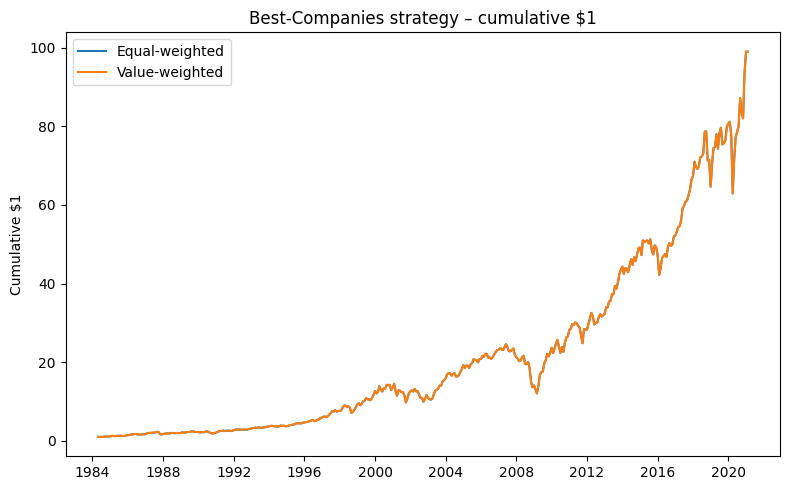

In [161]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, textwrap

RET_FILE = "bcw_portfolio_returns.parquet"

# -------------------------------------------------------
# 1. load & preview
# -------------------------------------------------------
df = pd.read_parquet(RET_FILE)

print("\nFirst 5 rows:")
print(df.head().to_string())
print("\nLast 5 rows:")
print(df.tail().to_string())

# -------------------------------------------------------
# 2. basic stats
# -------------------------------------------------------
stats = pd.DataFrame({
    "Mean":        df[["EW_ret","VW_ret"]].mean(),
    "StDev":       df[["EW_ret","VW_ret"]].std(),
})
stats["Sharpe (ann)"] = stats["Mean"]/stats["StDev"]*np.sqrt(12)

print("\nSummary statistics:")
print(stats.to_string(float_format=lambda x:f"{x:8.4f}"))

# -------------------------------------------------------
# 3. cumulative-growth plot
# -------------------------------------------------------
cum = (1+df[["EW_ret","VW_ret"]]).cumprod()
plt.figure(figsize=(8,5))
plt.plot(cum.index, cum["EW_ret"], label="Equal-weighted")
plt.plot(cum.index, cum["VW_ret"], label="Value-weighted")
plt.title("Best-Companies strategy – cumulative $1")
plt.ylabel("Cumulative $1")
plt.legend()
plt.tight_layout()
plt.show()


In [162]:
import pandas as pd, numpy as np, re

# 1. Load the freshly rebuilt return file
prt = pd.read_parquet("bcw_portfolio_returns.parquet")
print("\nHead of VW_ret after new Step 3:")
print(prt["VW_ret"].head(12))

# 2. How many VW_ret values are non-zero / non-NaN?
print("Non-NaN rows :", prt["VW_ret"].notna().sum())
print("Non-zero rows:", (prt["VW_ret"]!=0).sum())

# 3. Load factors (month-end stamps)
def load_ff_csv(path, colnames):
    """
    Robust Ken-French loader (comma *or* whitespace delimited)
    that keeps a month-end DatetimeIndex and converts only data columns.
    """
    import re, pandas as pd

    # detect delimiter and first monthly row
    start, delim = 0, r"\s+"
    with open(path) as fh:
        for i, line in enumerate(fh):
            if re.match(r"\s*\d{6},", line):  start, delim = i, "," ; break
            if re.match(r"\s*\d{6}\s", line): start, delim = i, r"\s+" ; break

    df = pd.read_csv(path, skiprows=start, sep=delim, engine="python", header=None)

    # keep only rows whose first col is 6 digits (YYYYMM)
    df = df[df[0].astype(str).str.match(r"^\d{6}$")].copy()

    # parse dates first ♦
    df[0] = (pd.to_datetime(df[0], format="%Y%m")
               .dt.to_period("M").dt.to_timestamp("M"))

    # rename columns
    df.columns = ["Date"] + colnames
    df = df.set_index("Date")

    # convert only the data columns to decimals
    df[colnames] = df[colnames].apply(pd.to_numeric, errors="coerce") / 100.0
    return df


ff3 = load_ff_csv("F-F_Research_Data_Factors.CSV",
                  ["Mkt-RF","SMB","HML","RF"])

print("\nFirst 5 factor dates :", ff3.index[:5])
print("First 5 return dates :", prt.index[:5])

print("\nRows that overlap :" ,
      len(prt.join(ff3, how="inner")))



Head of VW_ret after new Step 3:
month
1984-04-30    0.001398
1984-05-31   -0.058195
1984-06-30    0.050989
1984-07-31   -0.039333
1984-08-31    0.123326
1984-09-30   -0.008214
1984-10-31    0.005439
1984-11-30   -0.018925
1984-12-31    0.034196
1985-01-31    0.108370
1985-02-28    0.012540
1985-03-31   -0.018409
Name: VW_ret, dtype: float64
Non-NaN rows : 442
Non-zero rows: 441

First 5 factor dates : DatetimeIndex(['1926-07-31', '1926-08-31', '1926-09-30', '1926-10-31',
               '1926-11-30'],
              dtype='datetime64[ns]', name='Date', freq=None)
First 5 return dates : DatetimeIndex(['1984-04-30', '1984-05-31', '1984-06-30', '1984-07-31',
               '1984-08-31'],
              dtype='datetime64[ns]', name='month', freq=None)

Rows that overlap : 442


In [163]:
import pandas as pd, numpy as np, statsmodels.api as sm, matplotlib.pyplot as plt, re

def load_ff_csv(path, colnames):
    """Robust loader for Ken-French CSVs (comma *or* whitespace)."""
    start, delim = 0, r"\s+"
    with open(path) as fh:
        for i,l in enumerate(fh):
            if re.match(r"\s*\d{6},", l):  start, delim = i, "," ; break
            if re.match(r"\s*\d{6}\s", l): start, delim = i, r"\s+" ; break
    df = pd.read_csv(path, skiprows=start, sep=delim, engine="python", header=None)
    df = df[df[0].astype(str).str.match(r"^\d{6}$")].copy()
    df[0] = pd.to_datetime(df[0], format="%Y%m").dt.to_period("M").dt.to_timestamp("M")
    df.columns = ["Date"] + colnames
    df = df.set_index("Date")
    df[colnames] = df[colnames].apply(pd.to_numeric, errors="coerce")/100
    return df.sort_index()

# ---- data that every part needs ------------------------------------------
port = pd.read_parquet("bcw_portfolio_returns.parquet").sort_index()
EW, VW = port["EW_ret"].astype(float), port["VW_ret"].astype(float)

ff3   = load_ff_csv("F-F_Research_Data_Factors.CSV",
                    ["Mkt-RF","SMB","HML","RF"])
mom   = load_ff_csv("F-F_Momentum_Factor.CSV",
                    ["Mom"])
ff5   = load_ff_csv("F-F_Research_Data_5_Factors_2x3.CSV",
                    ["Mkt-RF","SMB","HML","RMW","CMA","RF"])
ind12 = load_ff_csv("12_Industry_Portfolios.CSV",
                    [f"Ind{i}" for i in range(1,13)])
factors = ff3.join(mom).join(ff5[["RMW","CMA"]])   # master table


## (a)

In [164]:
stats = pd.DataFrame({
    "Mean":  [EW.mean(), VW.mean()],
    "StDev": [EW.std(),  VW.std()]
}, index=["Equal-wt","Value-wt"])
stats["Sharpe (ann)"] = stats["Mean"]/stats["StDev"]*np.sqrt(12)
print(stats.to_string(float_format=lambda x:f"{x:8.4f}"))


             Mean    StDev  Sharpe (ann)
Equal-wt   0.0118   0.0509        0.8003
Value-wt   0.0118   0.0509        0.8003


## (b)

In [165]:
def hac_ols(y,X): return sm.OLS(y, sm.add_constant(X), missing="drop").fit(
                        cov_type="HAC", cov_kwds={"maxlags":12})

models = {
    "CAPM"   : ["Mkt-RF"],
    "FF3"    : ["Mkt-RF","SMB","HML"],
    "Carhart": ["Mkt-RF","SMB","HML","Mom"],
    "FF5"    : ["Mkt-RF","SMB","HML","RMW","CMA"]
}

for name,facs in models.items():
    d = factors[facs+["RF"]].join(VW, how="inner")
    res = hac_ols(VW.loc[d.index]-d["RF"], d[facs])
    print(f"{name:<8} α={res.params['const']:+.4f}  t={res.tvalues['const']:+.2f}")


CAPM     α=+0.0010  t=+1.05
FF3      α=+0.0010  t=+1.22
Carhart  α=+0.0021  t=+2.51
FF5      α=+0.0012  t=+1.43


## (c)

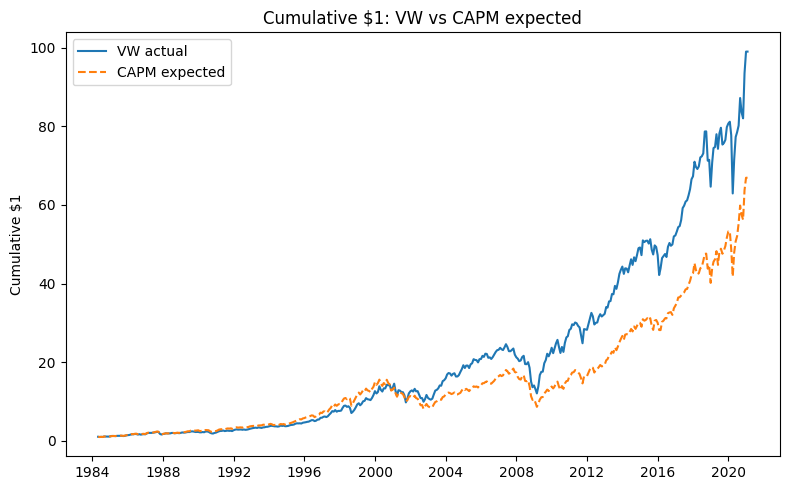

In [166]:
beta = hac_ols(VW - factors["RF"], factors[["Mkt-RF"]]).params["Mkt-RF"]
capm = factors[["Mkt-RF","RF"]].join(VW, how="inner")
exp  = capm["RF"] + beta*capm["Mkt-RF"]

plt.figure(figsize=(8,5))
plt.plot((1+VW.loc[capm.index]).cumprod(), label="VW actual")
plt.plot((1+exp).cumprod(), "--", label="CAPM expected")
plt.title("Cumulative $1: VW vs CAPM expected"); plt.ylabel("Cumulative $1")
plt.legend(); plt.tight_layout(); plt.show()


## (d)

In [147]:
def split_alpha(slc, tag):
    d = factors[["Mkt-RF","SMB","HML","Mom","RF"]].join(VW, how="inner").loc[slc]
    res = hac_ols(VW.loc[d.index]-d["RF"], d[["Mkt-RF","SMB","HML","Mom"]])
    print(f"{tag:<5} α={res.params['const']:+.4f}  t={res.tvalues['const']:+.2f}")

print("Carhart alpha split at 2010")
split_alpha(slice(None,"2009-12-31"), "pre")
split_alpha(slice("2010-01-01",None), "post")


Carhart alpha split at 2010
pre   α=+0.0031  t=+2.90
post  α=-0.0008  t=-0.99


## (e)

In [148]:
def ind_betas(slc, tag):
    d = ind12.join(VW, how="inner").loc[slc]
    res = sm.OLS(d["VW_ret"], sm.add_constant(d.drop(columns="VW_ret")), missing="drop").fit()
    print(f"\n{tag} betas:\n", res.params.drop("const").round(4).to_string())

ind_betas(slice(None,"1998-12-31"),  "Pre-1999")
ind_betas(slice("1999-01-01",None), "Post-1999")



Pre-1999 betas:
 Ind1     0.0025
Ind2    -0.0035
Ind3     0.0109
Ind4    -0.0027
Ind5    -0.0026
Ind6     0.0075
Ind7    -0.0022
Ind8     0.0069
Ind9    -0.0035
Ind10    0.0010
Ind11   -0.0059
Ind12   -0.0082

Post-1999 betas:
 Ind1     0.0005
Ind2     0.0000
Ind3     0.0007
Ind4    -0.0005
Ind5     0.0003
Ind6     0.0003
Ind7    -0.0005
Ind8     0.0008
Ind9    -0.0003
Ind10    0.0009
Ind11   -0.0003
Ind12   -0.0015
